# Example 9: $\chi \chi \to b \bar{b}$

In this notebook, we'll show you how to use the code to obtain the temperature and ionization histories for a dark matter particle with mass $m_\text{DM}$ that annihilates/decays into a pair of Standard Model particles with some (redshift-dependent) rate, characterized by either a thermally-averaged $s$-wave annihilation cross section $\langle \sigma v \rangle$ or a decay lifetime $\tau$. 

## Initialization

First, let's initialize some of the modules that are required. In order to perform the calculation, we need to point the code to a set of transfer functions that determine how high-energy particles in our code cool. 

The user must first download the data files located [*here*](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DUOUWA). When these files are required, the user will be prompted for the directory in which they are stored. To avoid this prompt, the directory can be entered into `data_path` defined in the [*config*](https://darkhistory.readthedocs.io/en/master/_autosummary/config.html) module. 

In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

In [2]:
%matplotlib inline

In [337]:
3000*np.exp(-.004*np.arange(162))

array([3000.        , 2988.02396803, 2976.09574451, 2964.21513859,
       2952.38196017, 2940.59601992, 2928.85712927, 2917.1651004 ,
       2905.51974624, 2893.92088045, 2882.36831746, 2870.86187242,
       2859.40136123, 2847.98660053, 2836.61740767, 2825.29360075,
       2814.01499859, 2802.78142073, 2791.59268743, 2780.44861968,
       2769.34903916, 2758.29376829, 2747.28263017, 2736.31544864,
       2725.39204821, 2714.51225411, 2703.67589226, 2692.88278929,
       2682.1327725 , 2671.42566989, 2660.76131015, 2650.13952265,
       2639.56013743, 2629.02298524, 2618.52789747, 2608.0747062 ,
       2597.66324418, 2587.29334483, 2576.96484222, 2566.67757111,
       2556.4313669 , 2546.22606564, 2536.06150405, 2525.93751951,
       2515.85395001, 2505.81063423, 2495.80741148, 2485.8441217 ,
       2475.92060548, 2466.03670403, 2456.19225923, 2446.38711356,
       2436.62111014, 2426.8940927 , 2417.20590562, 2407.55639389,
       2397.94540311, 2388.37277951, 2378.83836992, 2369.34202

In [ ]:
result['lowengelec']

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys

import main_dm_baryon_scattering as main

from tqdm import tqdm_notebook as tqdm

In [4]:
import config
from scipy.interpolate import interp1d

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

## Structure Formation

Dark matter annihilation rates are significantly enhanced after the formation of structures, owing to the fact that $\langle \rho^2 \rangle$ becomes greater than $\langle \rho_\text{DM} \rangle^2$, where $\rho_\text{DM}$ is the mass density of dark matter. To account for this increase in annihilation rate, boost factors, defined as

$$ 1 + \mathcal{B}(z) \equiv \frac{\langle \rho_\text{DM}^2 \rangle}{\langle \rho_\text{DM} \rangle^2} $$

have been computed under a wide variety of assumptions in the literature. The boost factor allows us to write the energy injection rate as

$$ \left( \frac{dE}{dV \, dt} \right)^\text{inj} = [1 + \mathcal{B}(z)] \left( \frac{dE}{dV \, dt} \right)^\text{inj}_\text{smooth} \,,$$

where the subscript 'smooth' indicates the smooth energy injection rate with the average mass density of dark matter assumed. 

In DarkHistory, we provide the 4 $s$-wave boost factors calculated in [[1]](#cite_2016), and shown in Fig. 2. We also include the $\text{erfc}$ model provided in [[2]](#cite_erfc), Eq. (2.7). The user can obtain these boost factors as *functions* that themselves return $1 + \mathcal{B}(z)$ as a function of redshift $1+z$, using [*struct_boost_func()*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.struct_boost_func.html) in [*physics*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics). See the documentation for details on how to use this function. Below, we use the "Einasto with substructure" model in [[1]](#cite_2016).

In [5]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
struct_boost_NFW = phys.struct_boost_func(model='NFW_no_subs')
struct_boost_pwave = phys.struct_boost_func(model='pwave_NFW_no_subs')

Let's plot this structure formation prescription to make sure that we have the right behavior. We'll make a plot of the effective density

$$ \rho_\text{eff} \equiv \sqrt{1 + \mathcal{B}(z)} \langle \rho_\text{DM} \rangle =  \sqrt{1 + \mathcal{B}(z)} \rho_{\text{DM},0} (1+z)^3 $$

where $\rho_{\text{DM},0}$ is the dark matter density today, which is stored in [*physics.rho_DM()*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.rho_DM.html). 

This plot should be directly compared with [[1]](#cite_2016). 

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


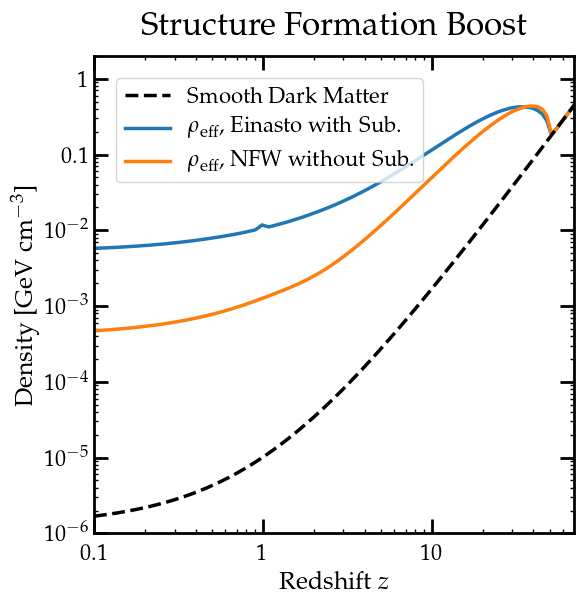

In [6]:
plt.figure()

plt.loglog()

z_vec = 10**np.arange(-1, 2, 0.005)
# Note that struct_boost accepts 1+z as the argument, which is the default
# way in which we pass redshift to functions in DarkHistory. 
rho_eff_vec = np.sqrt(struct_boost(1+z_vec)) * phys.rho_DM * (1+z_vec)**3 
rho_eff_vec_NFW = np.sqrt(struct_boost_NFW(1+z_vec)) * phys.rho_DM * (1+z_vec)**3 

# Convert to GeV/cm^3
rho_eff_vec /= 1e9
rho_eff_vec_NFW /= 1e9

rho_eff_plot,    = plt.plot(z_vec, rho_eff_vec, label=r'$\rho_\mathrm{eff}$, Einasto with Sub.')
rho_eff_plot_NFW,    = plt.plot(z_vec, rho_eff_vec_NFW, label=r'$\rho_\mathrm{eff}$, NFW without Sub.')
smooth_rho_plot, = plt.plot(z_vec, phys.rho_DM * (1+z_vec)**3 / 1e9, 'k--', label=r'Smooth Dark Matter')

plt.axis([0.1, 70, 1e-6, 2])
plt.xlabel('Redshift $z$')
plt.ylabel(r'Density [GeV cm$^{-3}$]')
plt.title('Structure Formation Boost')

plt.legend(handles=[smooth_rho_plot, rho_eff_plot, rho_eff_plot_NFW])

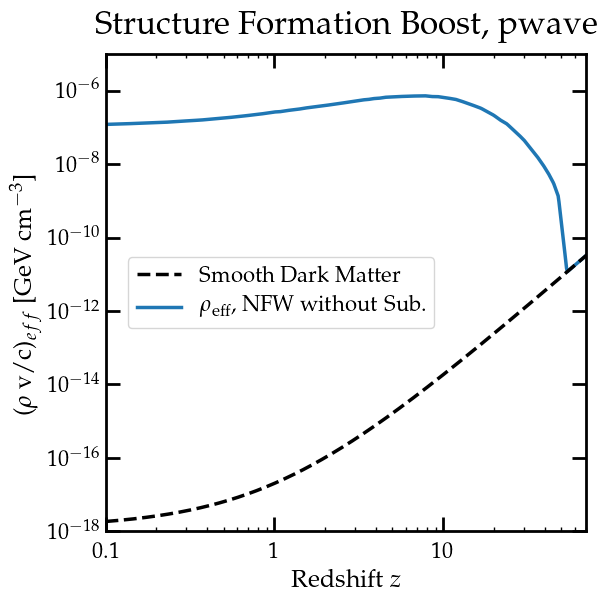

In [7]:
plt.figure()

plt.loglog()

z_vec = 10**np.arange(-1, 2, 0.005)

sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
rho_eff_vec_NFW = (sigma_1D_B/phys.c) * phys.rho_DM * (1+z_vec)**4 * np.sqrt(struct_boost_pwave(1+z_vec))

# Convert to GeV/cm^3
rho_eff_vec_NFW /= 1e9

# rho_eff_plot,    = plt.plot(z_vec, rho_eff_vec, label=r'$\rho_\mathrm{eff}$, Einasto with Sub.')
rho_eff_plot_NFW,    = plt.plot(z_vec, rho_eff_vec_NFW, label=r'$\rho_\mathrm{eff}$, NFW without Sub.')
smooth_rho_plot, = plt.plot(z_vec, 
                            (sigma_1D_B/phys.c) * phys.rho_DM * (1+z_vec)**4 / 1e9, 
                            'k--', label=r'Smooth Dark Matter')

plt.axis([0.1, 70, 1e-18, 1e-5])
plt.xlabel('Redshift $z$')
plt.ylabel(r'($\rho$ v/c)$_{eff}$ [GeV cm$^{-3}$]')
plt.title('Structure Formation Boost, pwave')

plt.legend(handles=[smooth_rho_plot, rho_eff_plot_NFW])

# pwave histories to compare against 1604.02457

In [65]:
%autoreload
pwave_noBR = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-24, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004, dm_baryon_switch=False, fDM=1
)

In [45]:
# %autoreload
# pwave_24BR = main.evolve(
#     DM_process='pwave', mDM=1e8, sigmav=3e-24, primary='phot_delta',
#     start_rs = 3000.,
#     coarsen_factor=4, backreaction=True,
#     struct_boost=struct_boost_pwave,
#     end_rs=4.004
# )

In [38]:
%autoreload
pwave23 = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-23, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004, dm_baryon_switch=False, fDM=1
)

In [47]:
# %autoreload
# pwave_23BR = main.evolve(
#     DM_process='pwave', mDM=1e8, sigmav=3e-23, primary='phot_delta',
#     start_rs = 3000.,
#     coarsen_factor=4, backreaction=True,
#     struct_boost=struct_boost_pwave,
#     end_rs=4.004
# )

In [39]:
%autoreload
pwave22 = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=3e-22, primary='phot_delta',
    start_rs = 3000.,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004, dm_baryon_switch=False, fDM=1
)

In [49]:
# %autoreload
# pwave_22BR = main.evolve(
#     DM_process='pwave', mDM=1e8, sigmav=3e-22, primary='phot_delta',
#     start_rs = 3000.,
#     coarsen_factor=4, backreaction=True,
#     struct_boost=struct_boost_pwave,
#     end_rs=4.004
# )

Now let's make a plot comparing these two results. Pull out the relevant information first:

In [66]:
# Redshift abscissa. Identical for both cases. 
rs_vec = pwave_noBR['rs']

# Tm, stored in eV and converted to K. 
Tm24 = pwave_noBR['Tm']/phys.kB
Tm23 = pwave23['Tm']/phys.kB
Tm22 = pwave22['Tm']/phys.kB

# Tm24BR = pwave_24BR['Tm']/phys.kB
# Tm23BR = pwave_23BR['Tm']/phys.kB
# Tm22BR = pwave_22BR['Tm']/phys.kB
# # Tm_BR   = bbbar_BR['Tm']/phys.kB

# xHII. 
xHII24 = pwave_noBR['x'][:,0]
xHII23 = pwave23['x'][:,0]
xHII22 = pwave22['x'][:,0]

# xHII24BR = pwave_noBR['x'][:,0]
# xHII23BR = pwave_23BR['x'][:,0]
# xHII22BR = pwave_22BR['x'][:,0]
# # xHII_BR   = bbbar_BR['x'][:,0]

And now the plotting!

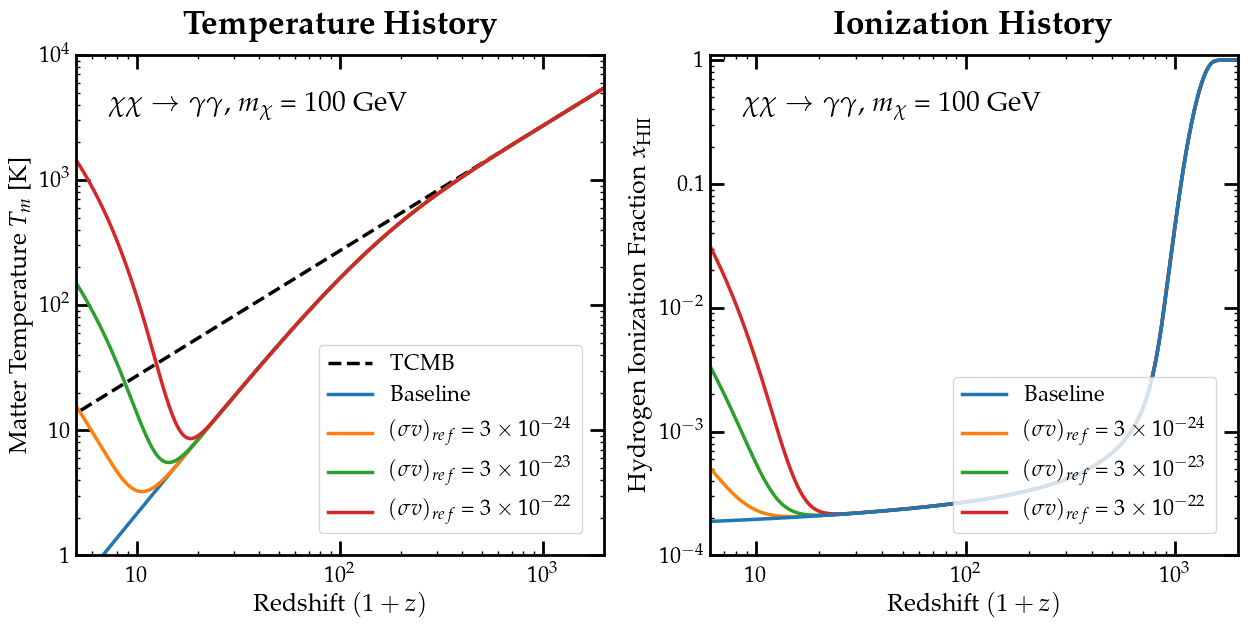

In [67]:
fig_bbbar = plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)

ax.loglog()

plot_Tm_std,    = plt.plot(rs_vec, phys.Tm_std(rs_vec)/phys.kB, 'C0', label='Baseline')
plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')
plot_Tm24,   = plt.plot(rs_vec, Tm24, 'C1', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
plot_Tm23,   = plt.plot(rs_vec, Tm23, 'C2', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
plot_Tm22,   = plt.plot(rs_vec, Tm22, 'C3', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

# plot_Tm24BR,   = plt.plot(rs_vec, Tm24BR, 'C1--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
# plot_Tm23BR,   = plt.plot(rs_vec, Tm23BR, 'C2--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
# plot_Tm22BR,   = plt.plot(rs_vec, Tm22BR, 'C3--', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

# plot_Tm_BR, = plt.plot(rs_vec, Tm_BR, label='With Backreaction')
# Plot the baseline result for comparison


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')

plt.axis([5, 2e3, 1, 1e4])

# Text
plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_TCMB, plot_Tm_std, plot_Tm24, plot_Tm23, plot_Tm22], loc=4)#, 
#                           plot_Tm24BR, plot_Tm23BR, plot_Tm22BR], loc=4)

#################

ax = plt.subplot(1,2,2)

ax.loglog()

plot_xHII24,   = plt.plot(rs_vec, xHII24, 'C1', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-24}$')
plot_xHII23,   = plt.plot(rs_vec, xHII23, 'C2', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-23}$')
plot_xHII22,   = plt.plot(rs_vec, xHII22, 'C3', label='$(\sigma v)_{ref}$ = $3 \\times 10^{-22}$')

# plot_xHII24BR,   = plt.plot(rs_vec, xHII24BR, 'C1--')
# plot_xHII23BR,   = plt.plot(rs_vec, xHII23BR, 'C2--')
# plot_xHII22BR,   = plt.plot(rs_vec, xHII22BR, 'C3--')
# # plot_xHII_BR, = plt.plot(rs_vec, xHII_BR, label='With Backreaction')
# # Plot the baseline result for comparison
plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C0', label='Baseline')

plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([6, 2e3, 1e-4, 1.1])

# Text
plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_xHII_std, plot_xHII24, plot_xHII23, plot_xHII22], loc=4)#, 
#                          plot_xHII24BR, plot_xHII23BR, plot_xHII22BR], loc=4)

# Compare to Fig. 1 of Hongwan/Tracy 21cm paper (also Histories_for_Comparison.ipynb)

Can we reproduce Fig. 1 of Hongwan/Tracy's 2016 paper? (Compare to Dropbox (MIT)/21cm_pwave/.../Example_Histories.ipynb)

In [44]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
inj_type = 'swave'
inj_param = 1e-29

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]

soln_std = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=inj_param*1e-60, primary='phot_delta',
    start_rs = rs_start,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [45]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
inj_type = 'swave'
inj_param = 1e-29

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2
soln_cooling = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=1e-40, primary='phot_delta',
    start_rs = rs_start, reion_switch=False,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [53]:
inj_param = 1e-29
mDM=1e8
soln_swave = main.evolve(
    DM_process='swave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_NFW,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [74]:
%autoreload
mDM = 3e6
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

init_cond = [phys.TCMB(rs_start), 0, V_pec_0,  .99999]



# mDM=3e6
lifetime = 8e25
# lifetime = 1e28
soln_decay = main.evolve(
    DM_process='decay', mDM=mDM, lifetime=lifetime, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [32]:
[sum(soln_decay['highengphot'][ind].N)*phys.nB* soln_decay['highengphot'].rs[ind]**3
 for ind in np.arange(len(soln_decay['highengphot'].rs))]

[6.560309339416612e-08,
 6.10778525544685e-06,
 8.971100051998592e-06,
 1.0181552014053797e-05,
 1.042745129167575e-05,
 1.0301693332145355e-05,
 1.0063178878843815e-05,
 9.813004251719591e-06,
 9.546436290001527e-06,
 9.280726792182934e-06,
 8.998361947236527e-06,
 8.717203736669325e-06,
 8.41298512491323e-06,
 8.094770250079045e-06,
 7.541504771672507e-06,
 7.022332689893336e-06,
 6.459891421308478e-06,
 5.752812188027143e-06,
 5.870481031958033e-06,
 5.829118452205132e-06,
 5.7374910453689186e-06,
 5.56044254030107e-06,
 5.423230632739e-06,
 5.351845271417436e-06,
 5.391115612166105e-06,
 5.505245828795149e-06,
 5.696991374988678e-06,
 5.95543908722544e-06,
 6.250960276142617e-06,
 6.546122555090696e-06,
 6.86442128446843e-06,
 7.128680148501153e-06,
 7.365283428746541e-06,
 7.5297644377677845e-06,
 7.625635108572216e-06,
 7.6013221326192715e-06,
 7.522777761654744e-06,
 7.368119044024796e-06,
 7.171467339355456e-06,
 6.931879491958289e-06,
 6.677378461930365e-06,
 6.414149458884964

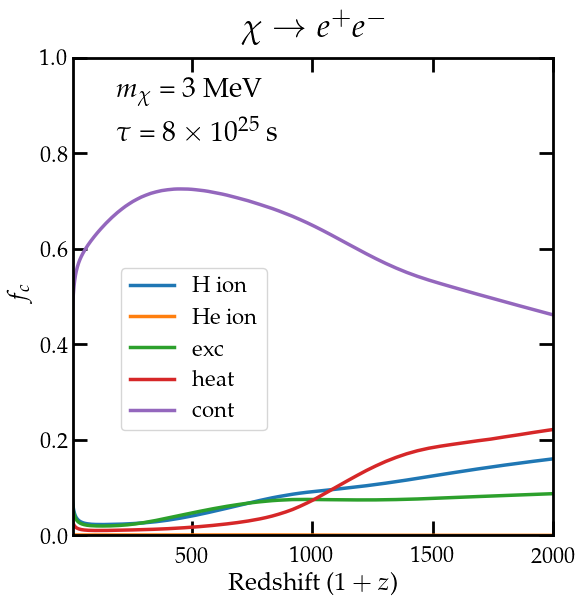

In [73]:
plt.figure()
ax = plt.gca()
# ax.loglog()

plt.axis([5,2e3,1e-4,1])
plt.xlabel(r'Redshift ($1+z$)')
plt.ylabel(r'$f_c$')
for chan in ['H ion', 'He ion', 'exc', 'heat', 'cont']:
    plt.plot(soln_decay['rs'],soln_decay['f']['low'][chan]+soln_decay['f']['high'][chan], label=chan)
    
# Text
plt.title(r'$\chi \to e^+ e^-$')
interval = .08
# plt.text(0.09, 0.93, r'$\chi \to e^+ e^-$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-0*interval-.02, r'$m_\chi$ = 3 MeV', fontsize=20, transform=ax.transAxes) 
# # plt.text(0.06, 0.88-interval*2-.02, r'$\langle \sigma v \rangle$ = $10^{-29}$ cm$^3$s$^{-1}$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-interval*2/2-.02, r'$\tau$ = $8 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

plt.legend(loc=(.1,.22))
plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/f_contours_3MeV.pdf')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x12ea37550> has a label of '_line2' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


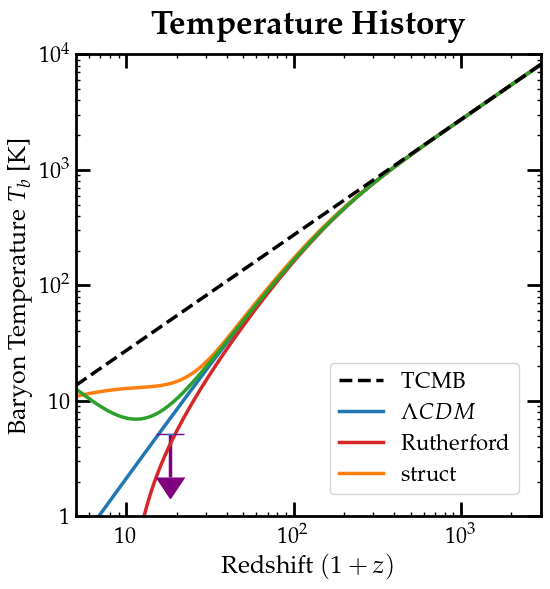

In [56]:
plt.figure(figsize=(6,6))
ax = plt.gca()

ax.loglog()

plot_Tm_std,    = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, 'C0', label='$\Lambda CDM$')
# plot_TDM_std,    = plt.plot(soln_std['rs'], soln_std['T_DM']/phys.kB, 'C0', linestyle = '--')

plot_Tm_cooling,    = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, 'C3', label='Rutherford')
plot_TDM_cooling,    = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, 'C3', linestyle = '--')

plot_Tm_swave,    = plt.plot(soln_swave['rs'], soln_swave['Tm']/phys.kB, 'C1', label='struct')

# plot_Tm_boost,    = plt.plot(soln_thermal_boost['rs'], soln_thermal_boost['Tm']/phys.kB, 'C2', label='cooling+boost', linestyle=':')
# plot_TDM_boost,    = plt.plot(soln_thermal_boost['rs'], soln_thermal_boost['T_DM']/phys.kB, 'C2', linestyle = '--')

# plot_Tm_pwave,    = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, 'C3', label='struct')

# plot_Tm_pwave_cooling,    = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['Tm']/phys.kB, 'C4', label='struct+pwave-boost')
# plot_TDM_pwave_cooling,    = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['T_DM']/phys.kB, 'C4', linestyle = '--')

# plot_Tm_total,    = plt.plot(soln_total['rs'], soln_total2['Tm']/phys.kB, 'C5', label='total', linestyle=':')
# plot_TDM_total,    = plt.plot(soln_total['rs'], soln_total2['T_DM']/phys.kB, 'C5', linestyle = '--')

plot_Tm_decay,    = plt.plot(soln_decay['rs'], soln_decay['Tm']/phys.kB, 'C2', label='decay')
# plot_Tm_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['Tm']/phys.kB, 'C2--', label='decay w/ BR')

# TDM_boost2, = plt.plot(tmp2['rs'], tmp2['T_DM']/phys.kB, color='C1', linestyle='--', label=r'DM')
# Tm_boost2, = plt.plot(tmp2['rs'], tmp2['Tm']/phys.kB, color='C3', linestyle='--', label=r'Struct Boost')
plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)

plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Baryon Temperature $T_b$ [K]')

plt.axis([5, 3e3, 1, 1e4]) 


# leg = plt.legend(handles=[plot_TCMB, plot_Tm_std], loc=4)
leg = plt.legend(handles=
                 [plot_TCMB, plot_Tm_std, plot_Tm_cooling, plot_TDM_cooling, plot_Tm_swave], loc=4)# plot_Tm_boost, 
                  #plot_Tm_pwave, plot_Tm_pwave_cooling, plot_Tm_total], loc=4)

# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/standard_hist.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decay_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decayBR_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/21cm_constraint.pdf')

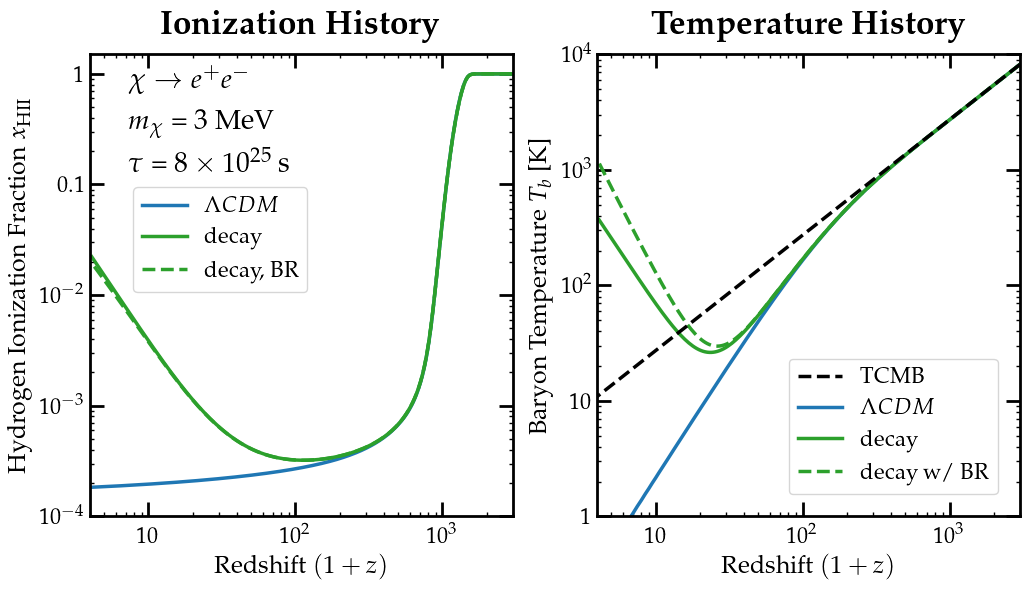

In [66]:
rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.loglog()

ax = plt.subplot(1,2,1)

ax.loglog()

plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C0', label='$\Lambda CDM$')
# plot_xHII_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['x'][:,0], 'C1', label='s-wave annihilation')
plot_xHII_decay,    = plt.plot(soln_decay['rs'], soln_decay['x'][:,0], 'C2', label='decay')
plot_xHII_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['x'][:,0], 'C2--', label='decay, BR')



plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([4, 3e3, 1e-4, 1.5])

# Text
interval = .08
plt.text(0.09, 0.93, r'$\chi \to e^+ e^-$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-interval-.02, r'$m_\chi$ = 3 MeV', fontsize=20, transform=ax.transAxes) 
# # plt.text(0.06, 0.88-interval*2-.02, r'$\langle \sigma v \rangle$ = $10^{-29}$ cm$^3$s$^{-1}$', fontsize=20, transform=ax.transAxes) 
plt.text(0.09, 0.93-interval*2-.02, r'$\tau$ = $8 \times 10^{25}$ s', fontsize=20, transform=ax.transAxes)

# Text
# plt.text(0.06, 0.88, r'$\chi \chi \to \gamma \gamma$, $m_\chi$ = 100 GeV', fontsize=20, transform=ax.transAxes) 
# plt.text(0.06, 0.82, r'$\langle \sigma v \rangle = 3 \times 10^{-24}$ cm$^3$ s$^{-1}$', fontsize=20, transform=ax.transAxes) 

leg = plt.legend(handles=[plot_xHII_std, plot_xHII_decay, plot_xHII_decayBR], loc="upper left", bbox_to_anchor=(0.05,0.76))
# leg = plt.legend(handles=[plot_xHII_std], loc="upper left", bbox_to_anchor=(0.05,0.76))


#################

ax = plt.subplot(1,2,2)

ax.loglog()

plot_Tm_std,    = plt.plot(rs_vec, phys.Tm_std(rs_vec)/phys.kB, 'C0', label='$\Lambda CDM$')
# plot_Tm_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['Tm']/phys.kB, 'C1', label='s-wave annihilation')
# plot_Tm_BR,    = plt.plot(soln_swave_BR['rs'], soln_swave_BR['Tm']/phys.kB, 'C1', linestyle='--',label='s-wave, w/ backreaction')

plot_Tm_decay,    = plt.plot(soln_decay['rs'], soln_decay['Tm']/phys.kB, 'C2', label='decay')
plot_Tm_decayBR,    = plt.plot(soln_decayBR['rs'], soln_decayBR['Tm']/phys.kB, 'C2--', label='decay w/ BR')


plot_TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='TCMB')

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Baryon Temperature $T_b$ [K]')

plt.axis([4, 3e3, 1, 1e4]) 


# leg = plt.legend(handles=[plot_TCMB, plot_Tm_std], loc=4)
leg = plt.legend(handles=[plot_TCMB, plot_Tm_std, plot_Tm_decay, plot_Tm_decayBR], loc=4)

# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/standard_hist.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decay_example.pdf')
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/decayBR_example.pdf')

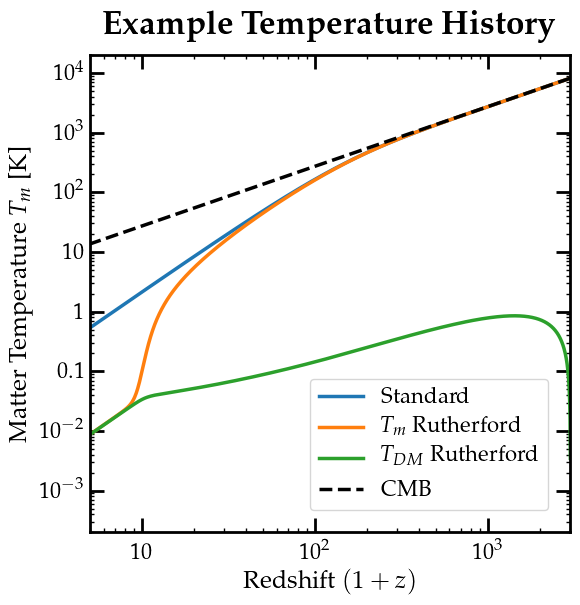

In [93]:
plt.figure()

ax = plt.gca()
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, label=r'Standard')
#Tm_swave, = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['Tm']/phys.kB, label=r'$s$-wave Annihilation')
#Tm_decay, = plt.plot(soln_decay2['rs'], soln_decay2['Tm']/phys.kB, label=r'Decay')
Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
# plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)
# Tm_decoupling, = plt.plot(soln_decoupling['rs'], soln_decoupling['Tm']/phys.kB, label=r'$(1+z)_\mathrm{td} = 500$')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
# Tm_pwave, = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, label=r'$p$-wave Annihilation')
# Tm_pwave_cooling, = plt.plot(soln_pwave_cooling['rs'], soln_pwave_cooling['Tm']/phys.kB, label=r'$p$-wave/Rutherford')
# Tm_boost, = plt.plot(tmp['rs'], tmp['Tm']/phys.kB, label=r'Everything')
# Tm_tmp, = plt.plot(tmp['rs'], tmp2['Tm']/phys.kB)
# Tm_tmp2, = plt.plot(tmp['rs'], tmp['T_DM']/phys.kB)



# Tm_pwave_cooling, = plt.plot(soln_pwave['rs'], soln_pwave['Tm']/phys.kB, label=r'$p$-wave and cooling')

plt.legend(handles=[Tm_std, Tm_cooling, TDM_cooling, TCMB], loc=4)
# plt.legend(handles=[Tm_std, Tm_swave, Tm_pwave, Tm_decay, Tm_cooling, TDM_cooling, Tm_pwave_cooling, Tm_boost, TCMB], loc=4)
# plt.legend(handles=[Tm_std, Tm_pwave, Tm_cooling, TDM_cooling, Tm_pwave_cooling, Tm_boost, Tm_tmp, TCMB], loc=4)

# plt.tick_params(axis='both', which='major', length=10, width=2, labelsize=20, direction='in', top=True, right=True)
# plt.tick_params(axis='both', which='minor', length=3, width=1, labelsize=20, direction='in', top=True, right=True)

plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 3e3, 0.0002, 2e4])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')

# Millicharge

## Compare to DH/21cm_pwave/Millicharged_DM.ipynb

In [63]:
%autoreload


mDM = 1e7
fDM = 1
n = -4

eps = 5e-6
inj_type = 'swave'
species = 'elec'
inj_param = 1e28*0
start_rs=2000

soln_swave_eps = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.03,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

[4, 3000.0, 1e-05, 2]

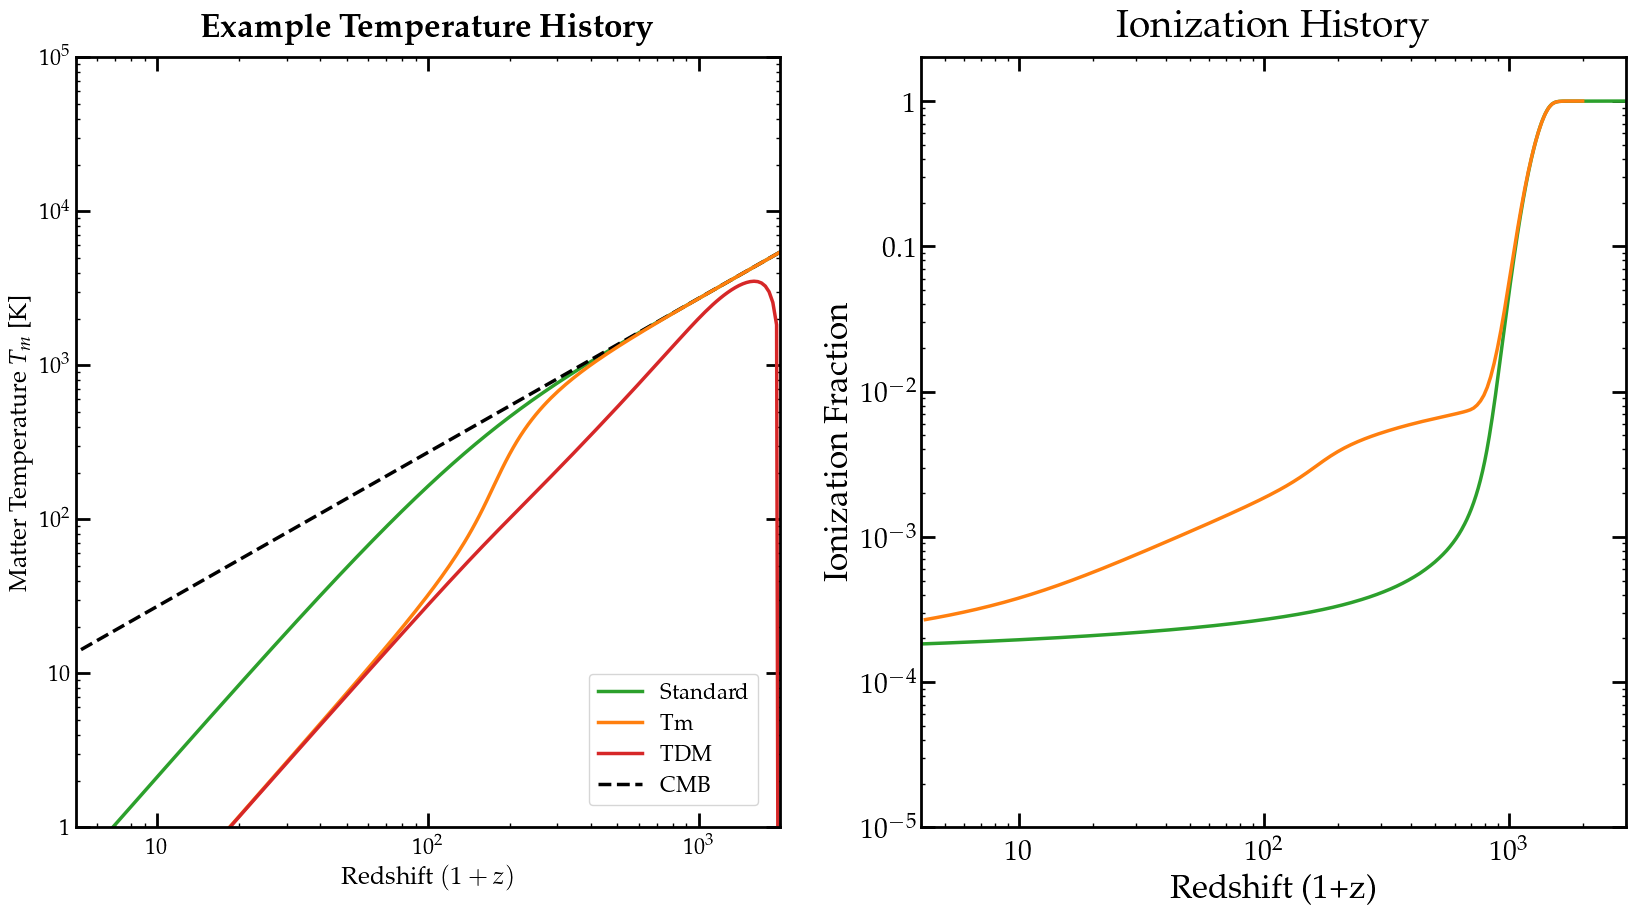

In [64]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, color='C2', label=r'Standard')
# Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
# TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_swave_eps_Tm, = plt.plot(soln_swave_eps['rs'], soln_swave_eps['Tm']/phys.kB, label='Tm', color='C1')
plt_swave_eps_TDM, = plt.plot(soln_swave_eps['rs'], soln_swave_eps['T_DM']/phys.kB, label='TDM', color='C3')

plt.legend(handles=[Tm_std, plt_swave_eps_Tm, plt_swave_eps_TDM, TCMB], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 2e3, 1, 1e5])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')



ax = plt.subplot(1,2,2)
plt.rc('text', usetex=True)
ax.loglog()

plot_xHII_std,    = plt.plot(rs_vec, phys.xHII_std(rs_vec), 'C2', label='$\Lambda CDM$')
# plot_xHII_swave,    = plt.plot(soln_swave_NFW['rs'], soln_swave_NFW['x'][:,0], 'C1', label='s-wave annihilation')
plot_xHII_decay,    = plt.plot(soln_swave_eps['rs'], soln_swave_eps['x'][:,0], 'C1', label='decay')


plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([4, 3e3, 1e-4, 1.5])

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title(r'Ionization History', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Ionization Fraction',fontsize=24)
plt.axis([4, 3e3, 1e-5, 2])

## Now compare to Figure 11 (d) of 1803.097539

We see if point ($m_{DM}$, $\epsilon$) = (10MeV, $4 \times 10^{-6}$) is ruled out as it should be, but ($m_{DM}$, $\epsilon$) = (10MeV, $5 \times 10^{-6}$) is not excluded.

In [75]:
%autoreload

mDM = 1e7
fDM = 1e-2
n = -4

eps = 4e-6
inj_type = 'swave'
species = 'phot'
inj_param = 1e28*0
start_rs=2000

soln_exc = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)


eps = 5e-6
soln_inc = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=4, backreaction=False,
    struct_boost=None,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

In [73]:
species = 'phot'

soln_exc_struct = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)


eps = 5e-6
soln_inc_struct = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=4, backreaction=False,
    struct_boost=struct_boost,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

[15, 20, 1, 20]

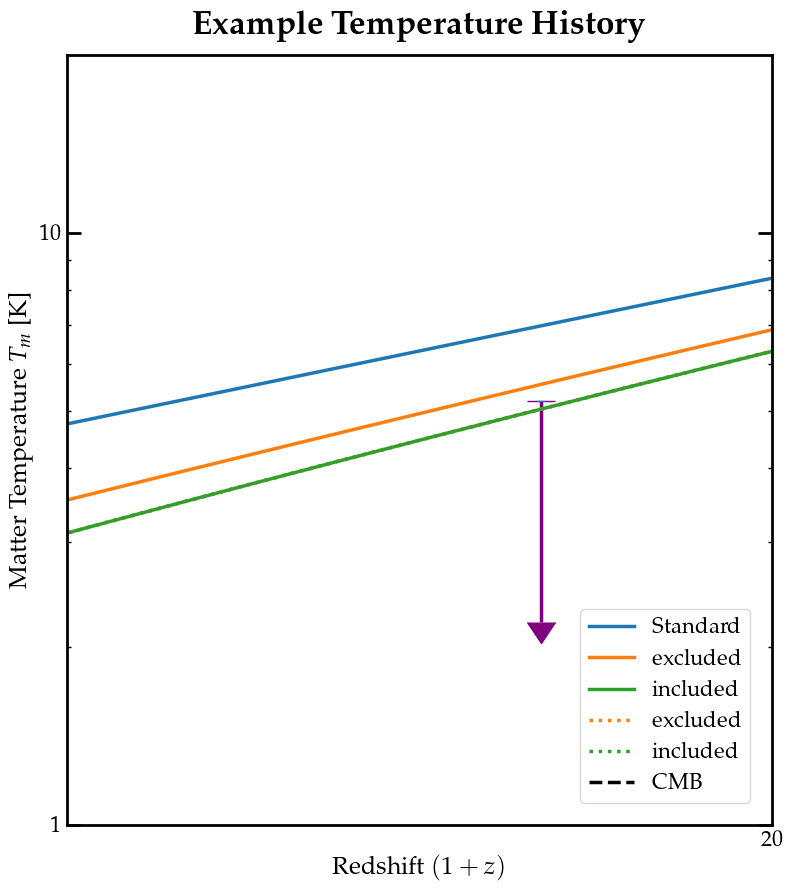

In [79]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, color='C0', label=r'Standard')

TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_exc, = plt.plot(soln_exc['rs'], soln_exc['Tm']/phys.kB, label='excluded', color='C1')
plt_inc, = plt.plot(soln_inc['rs'], soln_inc['Tm']/phys.kB, label='included', color='C2')

plt_exc_struct, = plt.plot(soln_exc_struct['rs'], soln_exc_struct['Tm']/phys.kB, label='excluded', color='C1', linestyle = ':')
plt_inc_struct, = plt.plot(soln_inc_struct['rs'], soln_inc_struct['Tm']/phys.kB, label='included', color='C2', linestyle = ':')

plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)
plt.legend(handles=[Tm_std, plt_exc, plt_inc, plt_exc_struct, plt_inc_struct, TCMB], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([15, 20, 1, 20])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')

## pwave

Importance of thermal boost (search for fac in rate_func_eng and set it to 0)

In [105]:
%autoreload
mDM = 1e7
fDM = 1e-2
n = -4

eps = 8e-4
inj_type = 'pwave'
species = 'elec'
start_rs=3000
if species == 'elec':
    coarsen_factor=32
else:
    coarsen_factor=4

soln_pwave_eps = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

In [81]:
%autoreload
soln_pwave_eps_noThermal = main.evolve(
    DM_process=inj_type, mDM=mDM, primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=15,
    dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=eps
)

In [335]:
struct_boost = phys.struct_boost_func(model='einasto_subs')
tmp = main.evolve(
    DM_process='swave', mDM=10**7.01, primary='phot_delta',
    start_rs = 3000, sigmav=5.2481*1e-26, lifetime=lifetime,
    coarsen_factor=4, backreaction=True,
    struct_boost=struct_boost,
    end_rs=4.01
)

In [329]:
fexc = datums['f']['low']['exc']+0*datums['f']['high']['exc']

In [330]:
fexc = datums['f']['low']['exc']+0*datums['f']['high']['exc']
rs_list = datums['lowengphot'].rs
nrms = phys.nB * rs_list**3 / (4*.001/phys.hubble(rs_list)) /(
    phys.inj_rate('decay', rs_list, mDM=mDM, sigmav=sigmav, lifetime=lifetime)
)
fexc2 = datums['lowengphot'].toteng(bound_type='eng',
                            bound_arr=np.array([phys.lya_eng,phys.rydberg])
                           )*nrms

[5, 2000.0, 1, 100000.0]

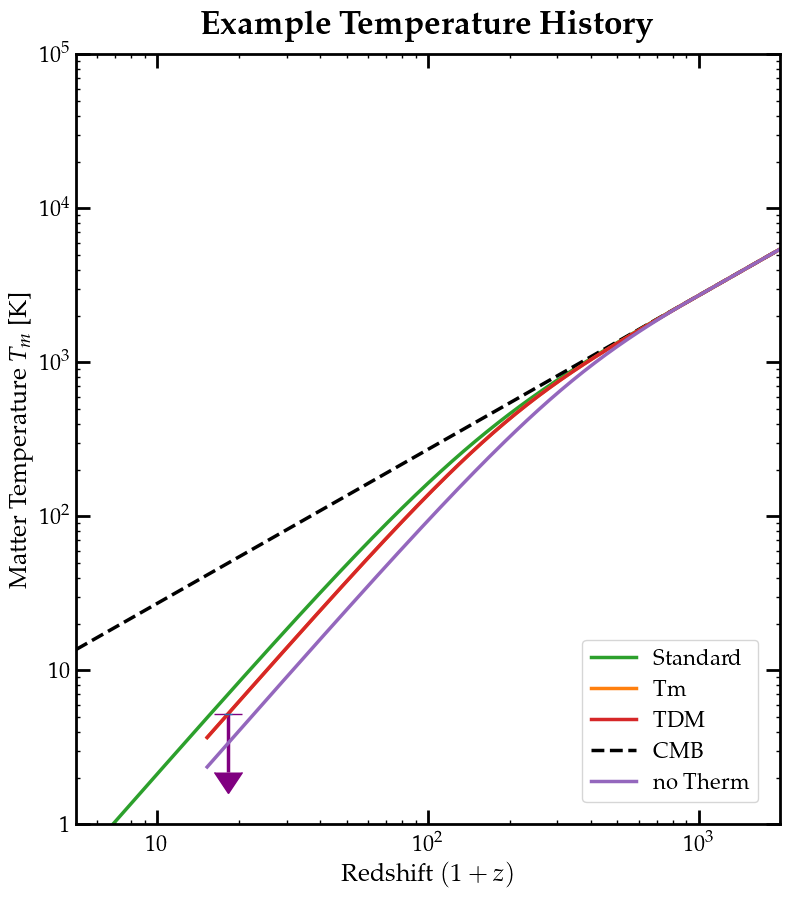

In [92]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_std['rs'], soln_std['Tm']/phys.kB, color='C2', label=r'Standard')
# Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
# TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_pwave_eps_Tm, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['Tm']/phys.kB, label='Tm', color='C1')
plt_pwave_eps_TDM, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['T_DM']/phys.kB, label='TDM', color='C3')
plt_pwave_eps_Tm_noThermal, = plt.plot(soln_pwave_eps_noThermal['rs'], soln_pwave_eps_noThermal['Tm']/phys.kB, label='no Therm', color='C4')

plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)

plt.legend(handles=[Tm_std, plt_pwave_eps_Tm, plt_pwave_eps_TDM, TCMB,
                   plt_pwave_eps_Tm_noThermal], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 2e3, 1, 1e5])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')

# Derive Constraints for p-wave model

In [109]:
%autoreload

fDM = 1e-2
n = -4
inj_type = 'pwave'
species = 'elec'
start_rs=3000

m_inc = .4
log10mDM_list = np.arange(6,8+m_inc-1e-10,m_inc)

eps_inc = .3
log10eps_list = np.arange(-6,-3+eps_inc-1e-10,eps_inc)

Tm_list = np.zeros((
    len(log10mDM_list),
    len(log10eps_list)
))

if species == 'elec':
    coarsen_factor=32
else:
    coarsen_factor=4

The loop

In [117]:
for i,log10mDM in enumerate(tqdm(log10mDM_list)):
    for j,log10eps in enumerate(tqdm(log10eps_list)):
        soln_pwave_eps = main.evolve(
            DM_process=inj_type, mDM=10**log10mDM, primary=species+'_delta',
            start_rs = start_rs,
            coarsen_factor=coarsen_factor, backreaction=True,
            struct_boost=struct_boost_pwave,
            end_rs=18.165,
            dm_baryon_switch=True, fDM=fDM, n=n, mcharge_switch=True, eps=10**log10eps
        )
        Tm_list[i,j] = soln_pwave_eps['Tm'][-1]/phys.kB

/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


../../darkhistory/history/tla_DM_baryon_scattering.py:117: RuntimeWarning: divide by zero encountered in log
  xi = np.log(9*T_matter**3/(4*phys.hbar**3*phys.c**3*np.pi*eps**2*phys.alpha**3*xHII*phys.nH*rs**3))


In [120]:
import pickle

In [125]:
# Save the data
pickle.dump(
    [log10mDM_list, log10eps_list, Tm_list],
    open('/Users/gregoryridgway/Dropbox (MIT)/21cm_pwave/08_13_2019/plot_data/Tm_grid_pwave_'+species+'_fDM_1e-2.dat','wb')
)

In [431]:
%autoreload
soln_pwave_eps_1e7_noboost = main.evolve(
    DM_process='pwave', mDM=1e7, primary='elec_delta',
    start_rs = 3000,
    coarsen_factor=32, backreaction=True,
    struct_boost=struct_boost_pwave,
    end_rs=18.165,
    dm_baryon_switch=True, fDM=1e-2, n=-4, mcharge_switch=True, eps=1e-3
)

In [411]:
soln_pwave_eps['Tm'][-1]/phys.kB

2.7476576162269963

In [415]:
soln_pwave_eps_1e9['Tm'][-1]/phys.kB

5.29703570561195

In [423]:
soln_pwave_eps_1e9_noboost['Tm'][-1]/phys.kB

5.297035586798212

In [425]:
soln_pwave_eps_1e7['Tm'][-1]/phys.kB

3.504365393499563

In [432]:
soln_pwave_eps_1e7_noboost['Tm'][-1]/phys.kB

3.5021164538138203

[5, 2000.0, 1, 100000.0]

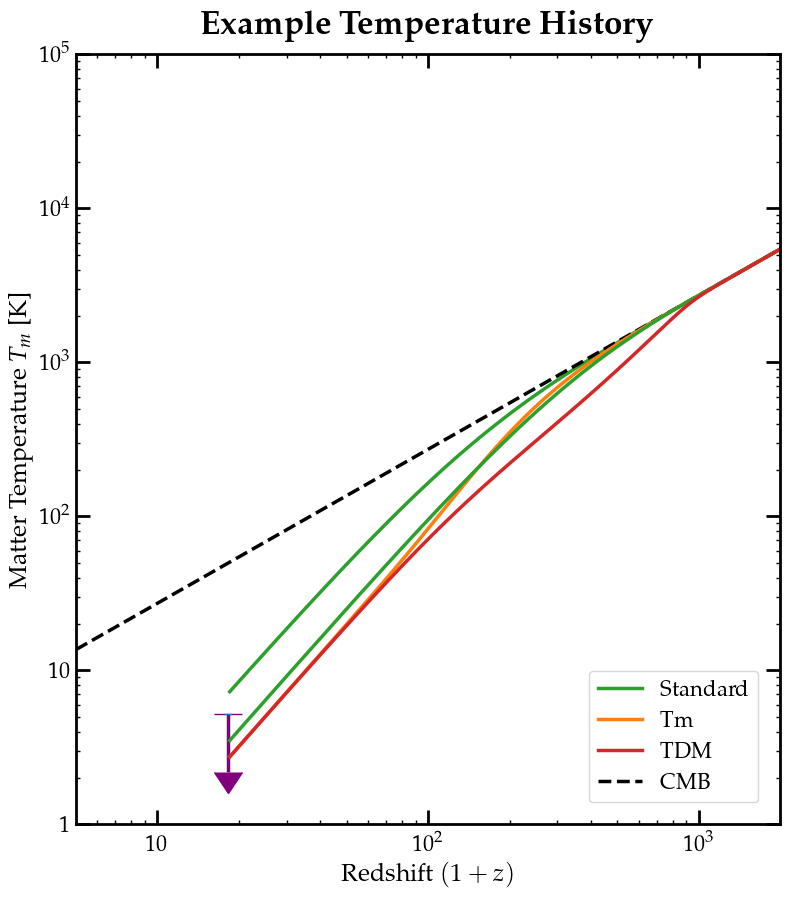

In [427]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)
ax.loglog()

Tm_std, = plt.plot(soln_pwave_eps['rs'], phys.Tm_std(soln_pwave_eps['rs'])/phys.kB, color='C2', label=r'Standard')
# Tm_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['Tm']/phys.kB, label=r'$T_m$ Rutherford')
# TDM_cooling, = plt.plot(soln_cooling['rs'], soln_cooling['T_DM']/phys.kB, label=r'$T_{DM}$ Rutherford')
TCMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB')
plt_pwave_eps_Tm, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['Tm']/phys.kB, label='Tm', color='C1')
plt_pwave_eps_Tm_1e7, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps_1e7['Tm']/phys.kB, label='Tm', color='C2')
plt_pwave_eps_TDM, = plt.plot(soln_pwave_eps['rs'], soln_pwave_eps['T_DM']/phys.kB, label='TDM', color='C3')
# plt_pwave_eps_Tm_noThermal, = plt.plot(soln_pwave_eps_noThermal['rs'], soln_pwave_eps_noThermal['Tm']/phys.kB, label='no Therm', color='C4')

plt.errorbar([18.2], [5.2], fmt="_", capsize=10, yerr=3, uplims=True, ecolor='Purple', linewidth=2.5)

plt.legend(handles=[Tm_std, plt_pwave_eps_Tm, plt_pwave_eps_TDM, TCMB], loc=4)
plt.title(r'\bf{Example Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([5, 2e3, 1, 1e5])
# plt.savefig('/Users/gregoryridgway/Desktop/DM/Talks/rutherford_example.pdf')

Make a contour plot

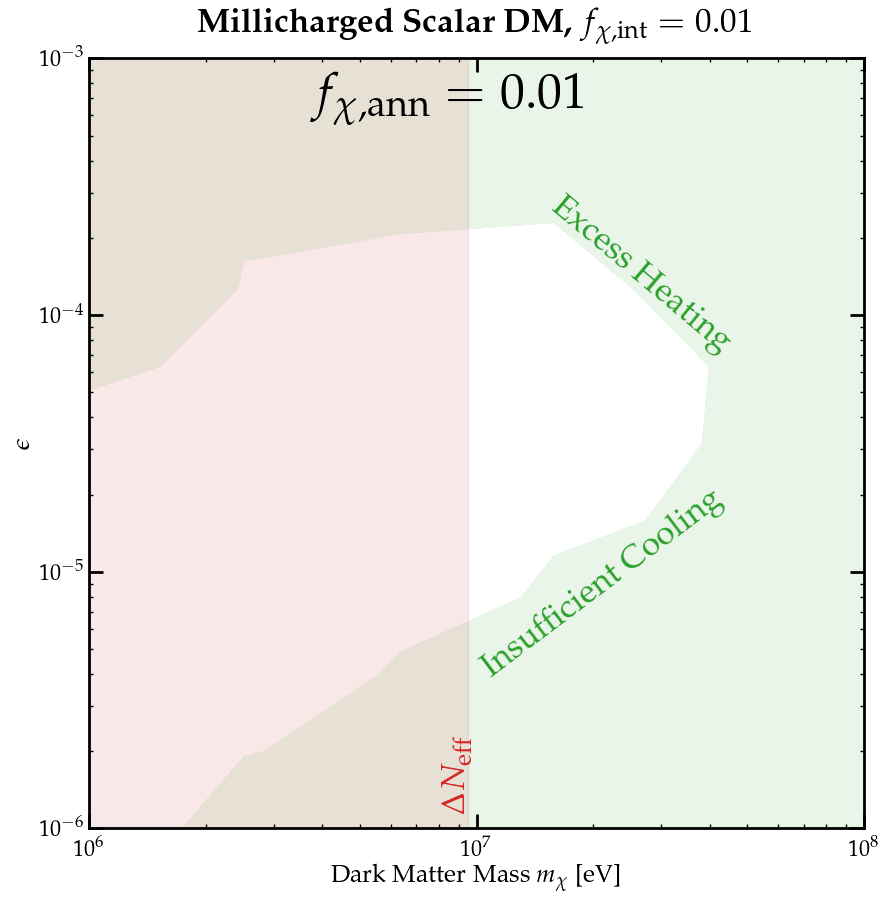

In [141]:
plt.figure(figsize=(10,10))

log10mDM_arr_fine = np.arange(6, 8, 0.05)
log10eps_arr_fine = np.arange(-6, -3, 0.05)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvspan(1e6, 9.5e6, color='C3', alpha=0.1)

plt.text(8.3e6, 1.8e-6, r'$\Delta N_\mathrm{eff}$', rotation=90, color='C3', fontsize=24)
plt.text(1e7, 1.8e-5, 'Insufficient Cooling', rotation=37, color='C2', fontsize=24)
plt.text(1.5e7, 2.5e-4, 'Excess Heating', color='C2', fontsize=24, rotation = -40)
plt.text(3.7e6, 6e-4, r'$f_{\chi,\mathrm{ann}} = 0.01$', fontsize=36)

lim_temp = plt.contourf(
    10**log10mDM_list, 10**log10eps_list, 
    np.transpose(Tm_list)/4,
    levels=[1,1e10], colors=['C2'], alpha=0.1
)

plt.axis([1e6, 1e8, 1e-6, 1e-3])

plt.title(r'\bf{Millicharged Scalar DM}, $f_{\chi,\mathrm{int}} = 0.01$')
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/21cm_pwave/08_13_2019/plots/millicharged_pwave_exclusion.png')

In [ ]:
plt.figure()

log10mDM_arr_fine = np.arange(6, 8, 0.05)
log10eps_arr_fine = np.arange(-6, -3, 0.05)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvspan(1e6, 9.5e6, color='C3', alpha=0.1)

plt.text(8.3e6, 1.8e-6, r'$\Delta N_\mathrm{eff}$', rotation=90, color='C3', fontsize=24)
plt.text(1e7, 1.5e-5, 'Insufficient Cooling', rotation=40, color='C2', fontsize=24)
plt.text(1.1e7, 7e-5, 'Excess Heating', color='C2', fontsize=24)
plt.text(1.5e6, 6e-4, r'Annihilation, $e^+e^-$, $f_{\chi,\mathrm{ann}} = 0.01$', fontsize=36)

lim_millicharged = plt.contour(
    10**log10mDM_arr_fine, 10**log10eps_arr_fine, 
    log10sigmav(log10mDM_arr_fine, log10eps_arr_fine),
    # Need to change from Majorana to Dirac
    levels=[-26-np.log10(2), -25.5-np.log10(2), -25-np.log10(2), -24.5-np.log10(2)],
#     levels = [-33.5, -32.5, -31.5, -31],
    colors=['C0','C1','C3','C2']
)

lim_temp = plt.contourf(
    10**log10mDM_arr, 10**log10eps_arr, 
    np.transpose(T_IGM_with_elec_ann_arr)/4,
    levels=[1,1e10], colors=['C2'], alpha=0.1
)

plt.axis([1e6, 1e8, 1e-6, 1e-3])


# labels = {
#     -33.5:r'-33.5', 
#     -32.5:r'-32.5', 
#     -31.5:r'-31.5', 
#     -31:r'-31'
# }

labels = {
    -26-np.log10(2):r'-26', 
    -25.5-np.log10(2):r'-25.5', 
    -25-np.log10(2):r'-25', 
    -24.5-np.log10(2):r'-24.5'
}

plt.clabel(
    lim_millicharged, inline=True, fontsize=16, rightside_up=True,
    manual=[(5e6, 2e-5), (1e7, 1e-5), (2e7, 3e-5), (6e7, 5e-5)], fmt=labels
)

plt.title(r'\bf{Millicharged DM}, $f_{\chi,\mathrm{int}} = 0.01$')
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')


plt.savefig('/Users/hongwan/Dropbox (MIT)/21cm_DM/drafts/PRD/v2/millicharged_elec_swave.pdf')

# Scratch

In [ ]:
inj_param = 3e-24
soln_pwave = main.evolve(
    DM_process='pwave', mDM=1e8, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=0, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [76]:
%autoreload
mDM = 1e8
fDM = 1
n = -4

# real scattering cross section is xsec*v**-n/mu**2
mu_p = mDM*1.22*phys.mp/(mDM + 1.22*phys.mp)
xsec = 3e-43*mu_p**2

rs_start = 3000
rs_vec = 1 + np.arange(0,rs_start-0.5,0.5)
rs_vec = np.flipud(rs_vec)

V_pec_0 = 3e-4*0

inj_param = 1e-26

soln_pwave_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=16,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [129]:
soln_std = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param*1e-40, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec*1e-40, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [138]:
soln_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param*1e-40, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [142]:
%autoreload
inj_param = 1e-26
soln_thermal_boost = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=None,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [153]:
%autoreload
inj_param = 1e-26
soln_pwave = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=False, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [166]:
%autoreload
inj_param = 1e-26
soln_pwave_cooling = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

In [257]:
%autoreload
inj_param = 1e-26
soln_total2 = main.evolve(
    DM_process='pwave', mDM=mDM, sigmav=inj_param, primary='elec_delta',
    start_rs = rs_start,
    coarsen_factor=32, backreaction=False,
    struct_boost=struct_boost_pwave,
    end_rs=4.004,
    dm_baryon_switch=True, xsec=xsec, fDM=fDM, n=n, mcharge_switch=False, eps=0
)

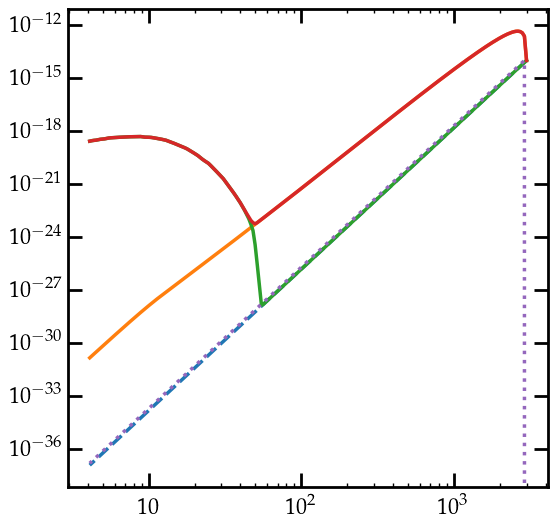

In [261]:
plt.figure()
ax = plt.gca()
ax.loglog()
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param),  linestyle='--')
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*fac)
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*struct_boost_pwave(soln_cooling['rs']))
plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*(
    fac-1+struct_boost_pwave(soln_cooling['rs'])))
# plt.plot(soln_cooling['rs'], phys.inj_rate('pwave', soln_cooling['rs'], mDM=mDM, sigmav=inj_param)*(
#     fac*struct_boost_pwave(soln_cooling['rs'])), color='C0')
plt.plot(soln_total['rs'], soln_total['V_pec'], linestyle=':')
# plt.plot(soln_total['rs'], soln_total['V_pec'], linestyle=':')
# plt.plot(soln_total['rs'], soln_pwave['V_pec'], color='C1')